# Laborator 3: Stress-Testing & Generalizare
## Impactul Zgomotului (Noise) și SMOTE asupra Overfitting-ului

**Student:** PEREBINOS DANIEL<br>
**Obiectiv:** Analiza modului în care calitatea datelor influențează capacitatea de generalizare a modelelor.

**Metodologie:**
1.  **Noise Injection:** Vom introduce erori intenționate în etichetele de antrenament (5%, 25%, 50%, 75%) pentru a forța modelele să "memoreze" date greșite.
2.  **Diagnostic:** Vom compara performanța pe Train (Date zgomotoase) vs. Test (Date curate - realitatea obiectivă).
    * **Overfitting:** Modelul învață zgomotul (Acuratețe mare pe Train, mică pe Test).
    * **Underfitting:** Modelul nu mai înțelege nimic (Acuratețe mică peste tot).
3.  **XAI (SHAP):** Vom vizualiza cum modelul începe să ia decizii haotice pe măsură ce zgomotul crește.
4.  **SMOTE:** Vom testa dacă datele sintetice ajută sau încurcă în acest scenariu.

In [32]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import warnings

# Dezactivarea avertismentelor neesențiale pentru claritate
warnings.filterwarnings('ignore')

# Configurare
sns.set(style="whitegrid")
np.random.seed(42)
tf.random.set_seed(42)

In [33]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Încărcare date
df = pd.read_csv('data/Churn_Modelling.csv')
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

df = pd.get_dummies(df, columns=['Geography'], drop_first=True)
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,1,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,0,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,0,False,True


In [34]:
X = df.drop('Exited', axis=1)
y = df['Exited']

In [35]:
# Split inițial (80% Train, 20% Test)
X_train_orig, X_test, y_train_orig, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scalare
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_orig)
X_test_sc = scaler.transform(X_test)

In [36]:
def inject_noise(y, noise_level):
    """
    Inversează etichetele pentru un procent 'noise_level' din date.
    Ex: Dacă noise_level=0.1, 10% din etichete sunt greșite (0 devine 1, 1 devine 0).
    """
    y_noisy = y.copy()
    n_samples = len(y)
    n_noise = int(n_samples * noise_level)

    if n_noise > 0:
        # Alegem indici aleatori
        noise_indices = np.random.choice(n_samples, n_noise, replace=False)

        if isinstance(y_noisy, pd.Series):
            y_noisy.iloc[noise_indices] = 1 - y_noisy.iloc[noise_indices]
        else:
            y_noisy[noise_indices] = 1 - y_noisy[noise_indices]

    return y_noisy

## EXPERIMENTUL 1: Progresia Zgomotului (Noise Injection Loop)

Vom itera prin nivelurile de zgomot: **5%, 25%, 50%, 75%**.
La fiecare pas:
1.  Corupem `y_train`.
2.  Antrenăm modelele.
3.  Măsurăm **Gap-ul**: `Train Score - Test Score`. Un gap mare înseamnă Overfitting masiv (modelul a tocit datele greșite).

In [37]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

noise_levels = [0.05, 0.25, 0.50, 0.75]
results = []

for noise in noise_levels:
    print(f"\n--- Rulare Experiment: Noise {int(noise*100)}% ---")

    # 1. Injectăm Zgomot
    y_train_noisy = inject_noise(y_train_orig, noise)

    # 2. Antrenare Modele

    # A. Logistic Regression
    lr = LogisticRegression(random_state=42)
    lr.fit(X_train_sc, y_train_noisy)
    acc_tr_lr = accuracy_score(y_train_noisy, lr.predict(X_train_sc))
    acc_te_lr = accuracy_score(y_test, lr.predict(X_test_sc))

    # B. Random Forest (Lăsăm adâncime mare să vedem overfitting-ul)
    rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
    rf.fit(X_train_orig, y_train_noisy) # RF merge pe date nescalate
    acc_tr_rf = accuracy_score(y_train_noisy, rf.predict(X_train_orig))
    acc_te_rf = accuracy_score(y_test, rf.predict(X_test))

    # C. Deep Learning
    dl = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_sc.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    dl.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    dl.fit(X_train_sc, y_train_noisy, epochs=20, batch_size=32, verbose=0)

    acc_tr_dl = dl.evaluate(X_train_sc, y_train_noisy, verbose=0)[1]
    acc_te_dl = dl.evaluate(X_test_sc, y_test, verbose=0)[1]

    # 3. Salvare Rezultate
    for model_name, tr, te in [('Logistic', acc_tr_lr, acc_te_lr),
                               ('Random Forest', acc_tr_rf, acc_te_rf),
                               ('Deep Learning', acc_tr_dl, acc_te_dl)]:

        # Diagnostic
        gap = tr - te
        if te < 0.6 and tr < 0.6:
            status = "Underfitting (Confuzie)"
        elif gap > 0.15:
            status = "Overfitting Sever (Memorare Zgomot)"
        elif gap > 0.05:
            status = "Overfitting Moderat"
        else:
            status = "Normal Fitting"

        results.append({
            'Noise Level': f"{int(noise*100)}%",
            'Noise': int(noise*100),
            'Model': model_name,
            'Train Acc (Noisy)': tr,
            'Test Acc (Clean)': te,
            'Generalization Gap': gap,
            'Status': status
        })

# Afișare tabelară
res_df = pd.DataFrame(results)
res_df


--- Rulare Experiment: Noise 5% ---

--- Rulare Experiment: Noise 25% ---

--- Rulare Experiment: Noise 50% ---

--- Rulare Experiment: Noise 75% ---


,Noise Level,Noise,Model,Train Acc (Noisy),Test Acc (Clean),Generalization Gap,Status
0,5%,5,Logistic,0.778125,0.8120,-0.033875,Normal Fitting
1,5%,5,Random Forest,0.997250,0.8655,0.131750,Overfitting Moderat
2,5%,5,Deep Learning,0.832250,0.8600,-0.027750,Normal Fitting
3,25%,25,Logistic,0.651125,0.8095,-0.158375,Normal Fitting
4,25%,25,Random Forest,0.990250,0.8250,0.165250,Overfitting Sever (Memorare Zgomot)
5,25%,25,Deep Learning,0.702000,0.8310,-0.129000,Normal Fitting
6,50%,50,Logistic,0.517875,0.5345,-0.016625,Underfitting (Confuzie)
7,50%,50,Random Forest,0.999125,0.4960,0.503125,Overfitting Sever (Memorare Zgomot)
8,50%,50,Deep Learning,0.608125,0.4910,0.117125,Overfitting Moderat
9,75%,75,Logistic,0.648875,0.1890,0.459875,Overfitting Sever (Memorare Zgomot)


### Vizualizarea "Prăbușirii" Modelelor
Graficul de mai jos arată esența overfitting-ului indus de zgomot:
* **Linia Train (Punctată):** Rămâne sus (modelele complexe precum RF memorează erorile).
* **Linia Test (Continuă):** Se prăbușește pe măsură ce zgomotul crește.
* **Distanța dintre ele:** Este măsura exactă a Overfitting-ului.

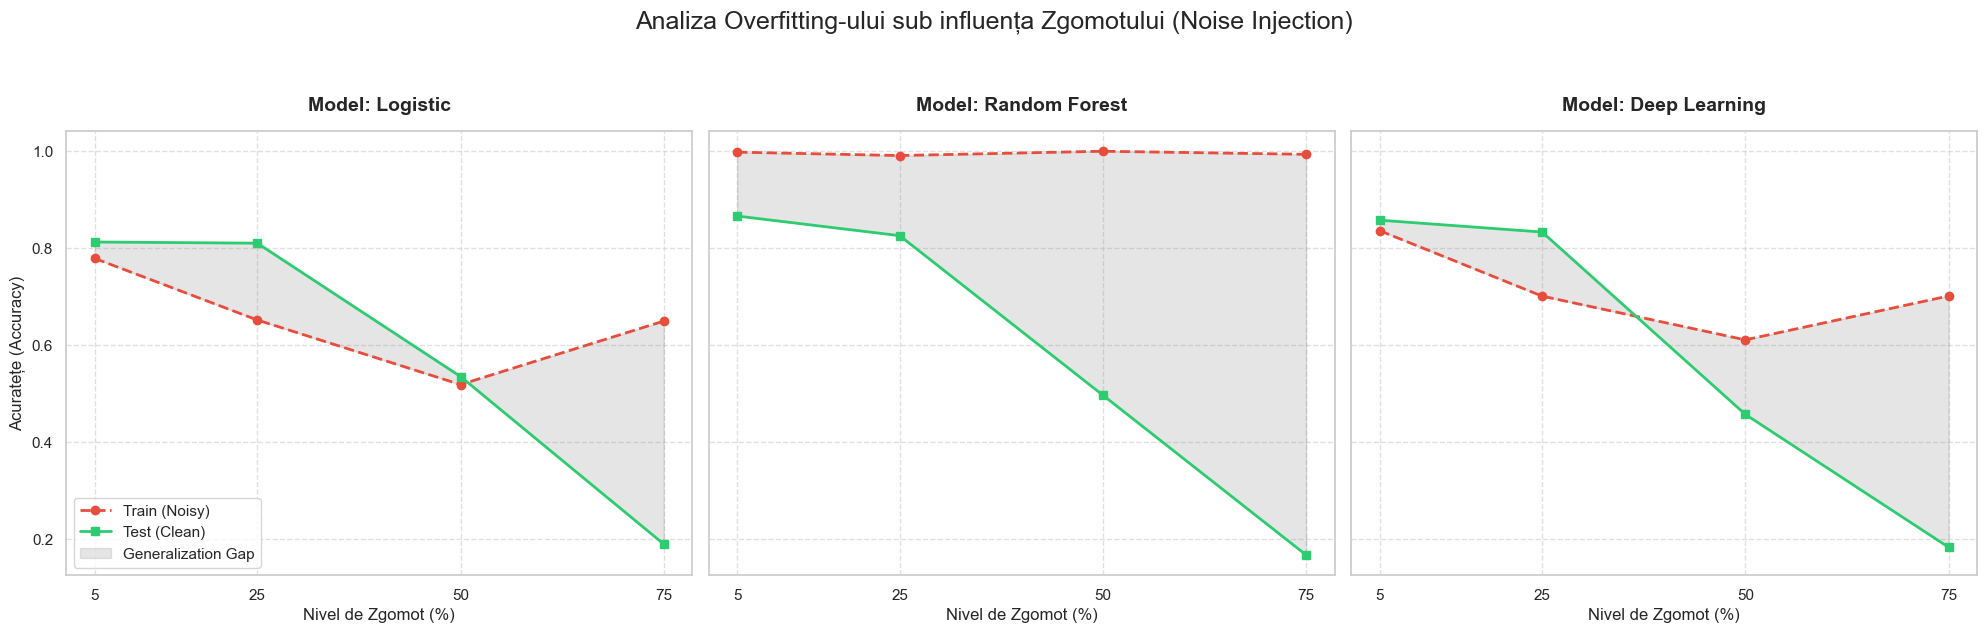

In [44]:
import matplotlib.pyplot as plt

# 2. Configurare Vizualizare Multiplă (1 rând, 3 coloane)
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

models = ['Logistic', 'Random Forest', 'Deep Learning']
colors = {'Train': '#e74c3c', 'Test': '#2ecc71', 'Fill': 'gray'} # Roșu/Verde/Gri

for i, model_name in enumerate(models):
    ax = axes[i]
    subset = res_df[res_df['Model'] == model_name]

    # Plotare linii
    ax.plot(subset['Noise Numeric'], subset['Train Acc (Noisy)'],
            marker='o', linestyle='--', linewidth=2, color=colors['Train'], label='Train (Noisy)')

    ax.plot(subset['Noise Numeric'], subset['Test Acc (Clean)'],
            marker='s', linestyle='-', linewidth=2, color=colors['Test'], label='Test (Clean)')

    # Evidențiere "Overfitting Zone" (Gap-ul)
    ax.fill_between(subset['Noise Numeric'],
                    subset['Train Acc (Noisy)'],
                    subset['Test Acc (Clean)'],
                    color=colors['Fill'], alpha=0.2, label='Generalization Gap')

    # Titluri și etichete
    ax.set_title(f"Model: {model_name}", fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel("Nivel de Zgomot (%)")
    ax.set_xticks([5, 25, 50, 75]) # Setăm tick-urile exact pe valorile noastre
    ax.grid(True, linestyle='--', alpha=0.6)

    # Adăugăm legenda doar pe primul grafic pentru a nu aglomera
    if i == 0:
        ax.set_ylabel("Acuratețe (Accuracy)")
        ax.legend(loc='lower left', frameon=True)

# Titlu general
plt.suptitle('Analiza Overfitting-ului sub influența Zgomotului (Noise Injection)', fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

## EXPERIMENTUL 2 EXTINS: Analiza SHAP Comparativă (Toate Modelele vs. Toate Nivelurile de Zgomot)

În această etapă, vom vizualiza **degradarea logicii decizionale**. Vom genera o matrice de grafice (3 modele x 4 niveluri de zgomot) pentru a răspunde la întrebarea:
* *"Cum se schimbă importanța caracteristicilor (Feature Importance) atunci când modelul este antrenat pe date din ce în ce mai greșite?"*

Ne așteptăm ca:
1.  **Modelele Robuste (ex: Logistic Regression)** să își păstreze relativ stabilă ierarhia caracteristicilor.
2.  **Modelele Complexe (ex: Random Forest, DL)** să devină haotice la zgomot mare (50-75%), acordând importanță unor trăsături irelevante.

In [39]:
import shap

# Configurare Parametri
noise_levels = [0.05, 0.25, 0.50, 0.75]
models_names = ['Logistic Regression', 'Random Forest', 'Deep Learning']

# Funcție helper pentru construirea modelului Deep Learning (DL)
def build_dl_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_sc.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("Configurarea experimentului SHAP completă.")

Configurarea experimentului SHAP completă.


### Notă Tehnică: Optimizarea SHAP pentru Deep Learning
Calcularea valorilor SHAP exacte pentru rețele neuronale (folosind `KernelExplainer`) este extrem de costisitoare computațional.
Pentru a putea rula acest experiment într-un timp rezonabil în laborator, vom folosi o aproximare:
* **Background Data:** Vom folosi un eșantion de doar 50 de exemple din setul de antrenament ca referință.
* **Test Data:** Vom explica deciziile pentru doar 50 de exemple din setul de test.

In [40]:
# Eșantionare pentru viteză (SHAP pe tot setul ar dura ore întregi la DL)
# Folosim shap.sample pentru a lua 50 de puncte reprezentative
background_data = shap.sample(X_train_sc, 50)
test_sample = X_test_sc[:50]

feature_names = X_test.columns.tolist()
test_sample_df = pd.DataFrame(test_sample, columns=feature_names) # Pt vizualizare cu nume

print(f"Dimensiune Background SHAP: {background_data.shape}")
print(f"Dimensiune Test Sample SHAP: {test_sample.shape}")

Dimensiune Background SHAP: (50, 11)
Dimensiune Test Sample SHAP: (50, 11)


Generare grafice SHAP Custom (Matplotlib pur)...
 > Logistic Regression | Noise: 5%
 > Logistic Regression | Noise: 25%
 > Logistic Regression | Noise: 50%
 > Logistic Regression | Noise: 75%
 > Random Forest | Noise: 5%
 > Random Forest | Noise: 25%
 > Random Forest | Noise: 50%
 > Random Forest | Noise: 75%
 > Deep Learning | Noise: 5%


  0%|          | 0/50 [00:00<?, ?it/s]

 > Deep Learning | Noise: 25%


  0%|          | 0/50 [00:00<?, ?it/s]

 > Deep Learning | Noise: 50%


  0%|          | 0/50 [00:00<?, ?it/s]

 > Deep Learning | Noise: 75%


  0%|          | 0/50 [00:00<?, ?it/s]

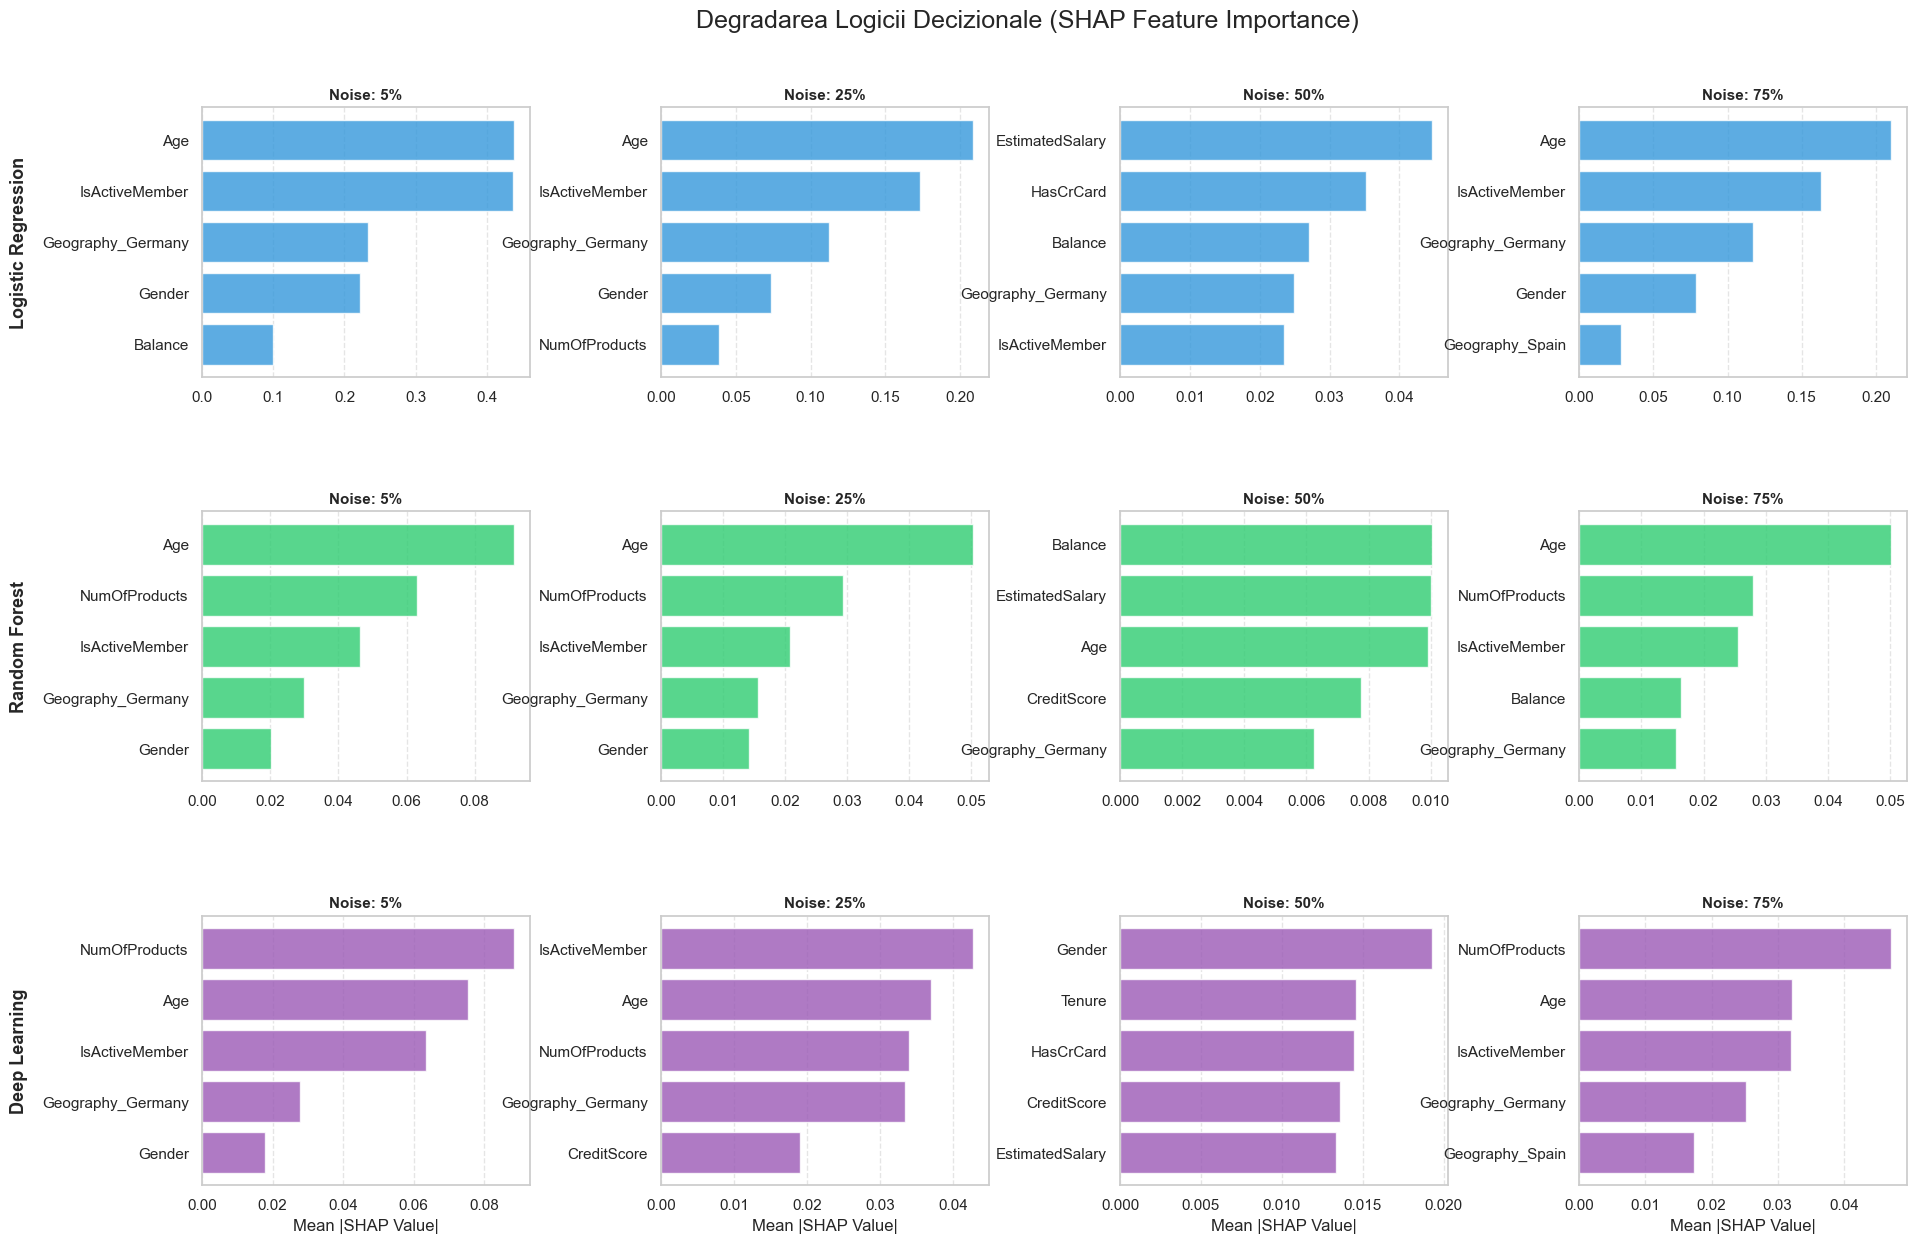

In [41]:
from functools import partial

# Configurare stil
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

# Parametri
noise_levels = [0.05, 0.25, 0.50, 0.75]
models_names = ['Logistic Regression', 'Random Forest', 'Deep Learning']
# Culori specifice pentru fiecare model
model_colors = {'Logistic Regression': '#3498db', 'Random Forest': '#2ecc71', 'Deep Learning': '#9b59b6'}

# --- Helper: Model DL ---
def build_dl_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_sc.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- Helper: Extragere Date SHAP (FIXAT) ---
def get_feature_importance(shap_values, feature_names_list):
    """Calculează media valorilor absolute SHAP robust."""
    vals = shap_values

    # 1. Tratăm cazul LISTĂ (specific KernelExplainer uneori)
    if isinstance(shap_values, list):
        if len(shap_values) > 1:
            vals = shap_values[1] # Luăm clasa pozitivă dacă există 2
        else:
            vals = shap_values[0] # Luăm singura ieșire existentă

    # 2. Conversie la numpy array pentru verificare dimensiuni
    vals_arr = np.array(vals)

    # 3. Tratăm cazul 3D ARRAY (samples, features, outputs)
    if len(vals_arr.shape) == 3:
        # Verificăm câți output-uri avem pe axa 2
        if vals_arr.shape[2] > 1:
            vals = vals_arr[:, :, 1] # Luăm index 1 (Clasa Pozitivă)
        else:
            vals = vals_arr[:, :, 0] # Luăm index 0 (Singura ieșire)
    else:
        vals = vals_arr

    # Calculăm media valorilor absolute pe coloane (Mean |SHAP|)
    importances = np.mean(np.abs(vals), axis=0)

    # Creăm DataFrame
    df_imp = pd.DataFrame({'Feature': feature_names_list, 'Importance': importances})
    df_imp = df_imp.sort_values(by='Importance', ascending=True)
    return df_imp

# --- Configurare SHAP Sampling ---
background_data = shap.sample(X_train_sc, 50)
test_sample = X_test_sc[:50]
feat_names_list = X.columns.tolist()

# --- PLOT SETUP ---
fig, axes = plt.subplots(3, 4, figsize=(22, 14))
plt.subplots_adjust(hspace=0.5, wspace=0.4)

print("Generare grafice SHAP Custom (Matplotlib pur)...")

for row, model_name in enumerate(models_names):
    for col, noise in enumerate(noise_levels):
        print(f" > {model_name} | Noise: {int(noise*100)}%")

        # 1. Injectare Zgomot
        y_train_noisy = inject_noise(y_train_orig, noise)

        # 2. Antrenare & Calcul SHAP
        shap_values = None
        X_target = None # Setul folosit pentru calcul (poate diferi ca tip: df vs array)

        if model_name == 'Logistic Regression':
            model = LogisticRegression(random_state=42)
            model.fit(X_train_sc, y_train_noisy)
            explainer = shap.LinearExplainer(model, X_train_sc)
            shap_values = explainer.shap_values(X_test_sc)

        elif model_name == 'Random Forest':
            model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
            model.fit(X_train_orig, y_train_noisy)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)

        elif model_name == 'Deep Learning':
            model = build_dl_model()
            model.fit(X_train_sc, y_train_noisy, epochs=10, verbose=0)
            explainer = shap.KernelExplainer(partial(model.predict, verbose=0), background_data, verbose=0)
            shap_values = explainer.shap_values(test_sample, nsamples=100)

        # 3. EXTRAGERE DATE (Funcția reparată)
        df_imp = get_feature_importance(shap_values, feat_names_list)

        # Luăm doar TOP 5 caracteristici
        df_top = df_imp.tail(5)

        # 4. PLOTARE CUSTOM
        ax = axes[row, col]

        # Bar Plot Orizontal
        ax.barh(df_top['Feature'], df_top['Importance'], color=model_colors[model_name], alpha=0.8)

        # Stilizează axa
        ax.set_title(f"Noise: {int(noise*100)}%", fontsize=11, fontweight='bold')
        ax.set_xlabel("Mean |SHAP Value|" if row == 2 else "")

        # Grid
        ax.grid(axis='x', linestyle='--', alpha=0.5)
        ax.grid(visible=False, axis='y') # Sintaxa corectă pentru a ascunde liniile orizontale

        # Dacă e prima coloană, punem numele modelului mare în stânga
        if col == 0:
            ax.set_ylabel(model_name, fontsize=13, fontweight='bold', labelpad=10)

# Titlu General
plt.suptitle("Degradarea Logicii Decizionale (SHAP Feature Importance)", fontsize=18, y=0.95)
plt.show()

**Interpretare XAI:**
La **50% Zgomot**, barele SHAP ar trebui să fie mult mai mici (impact redus) sau ordinea să fie complet ilogică. Modelul, fiind confuz, nu mai acordă importanță corectă vârstei sau scorului de credit, ci încearcă să găsească corelații în zgomot, care nu există.

## EXPERIMENTUL 3: Adăugarea SMOTE (Supra-eșantionare)
Acum luăm datele cu **25% Noise** (un scenariu mediu) și aplicăm **SMOTE**.
Întrebarea de cercetare: *SMOTE va ajuta modelul sau va amplifica zgomotul?*

Riscul SMOTE: Deoarece SMOTE creează vecini sintetici, dacă aplicăm SMOTE pe puncte "zgomotoase" (etichetate greșit), vom crea și mai multe puncte greșite sintetice, consolidând eroarea modelului.


--- RULARE EXPERIMENT: NOISE 0% ---
Running Baseline models (Noise 0%)...
Applying SMOTE on data with 0% noise...


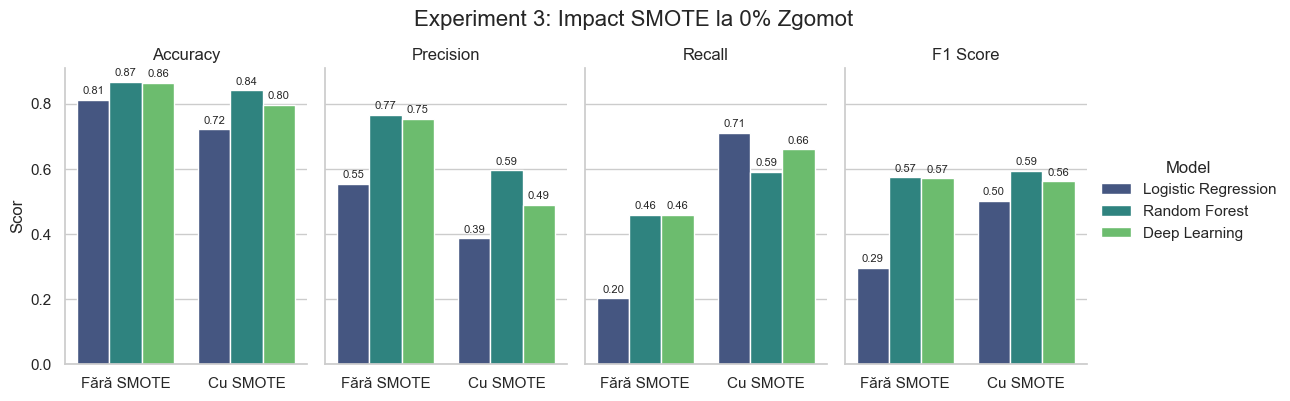


--- RULARE EXPERIMENT: NOISE 25% ---
Running Baseline models (Noise 25%)...
Applying SMOTE on data with 25% noise...


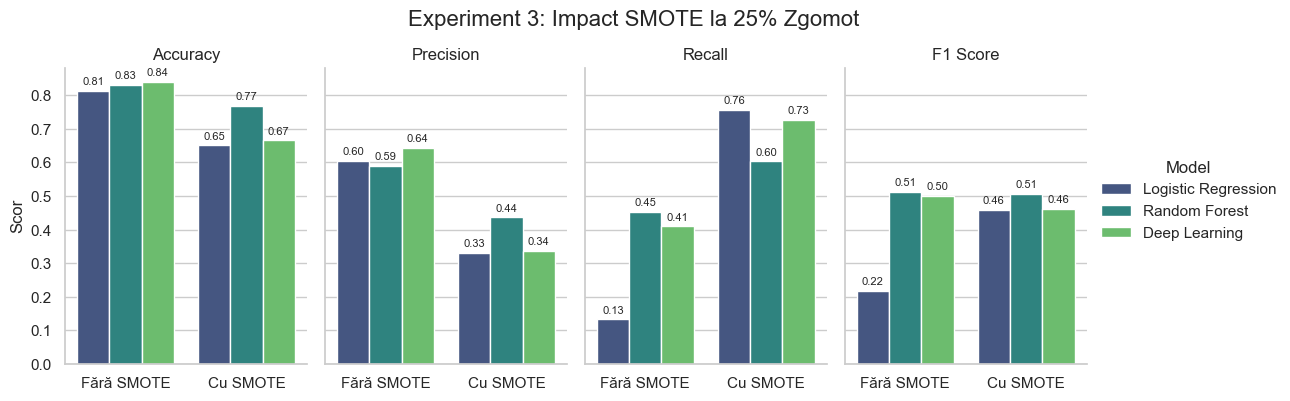


--- RULARE EXPERIMENT: NOISE 50% ---
Running Baseline models (Noise 50%)...
Applying SMOTE on data with 50% noise...


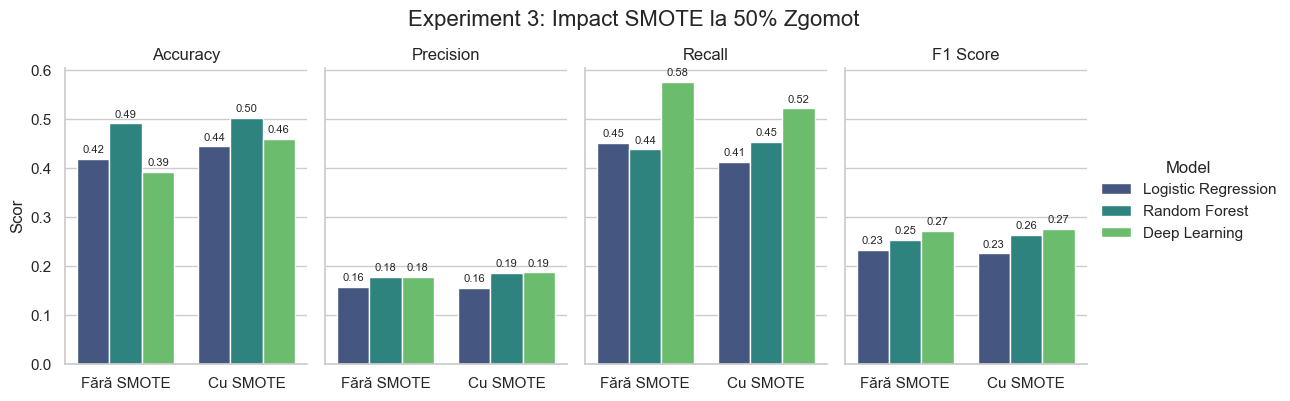


--- RULARE EXPERIMENT: NOISE 75% ---
Running Baseline models (Noise 75%)...
Applying SMOTE on data with 75% noise...


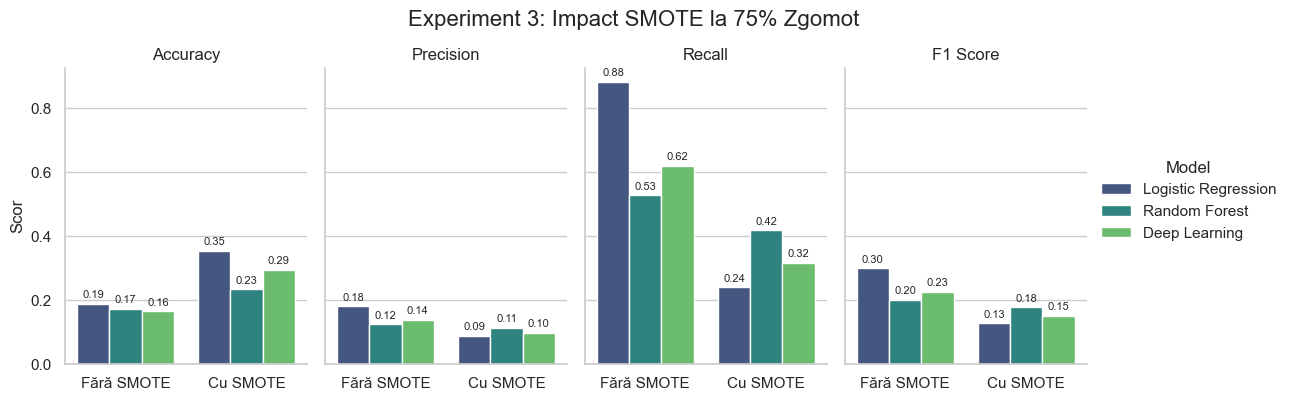


REZULTATE FINALE AGREGATE (TOATE NIVELURILE DE ZGOMOT)


,Noise Level,Model,Scenario,Accuracy,Precision,Recall,F1 Score
5,0%,Deep Learning,Cu SMOTE,0.7970,0.487759,0.659033,0.560606
2,0%,Deep Learning,Fără SMOTE,0.8640,0.753138,0.458015,0.569620
3,0%,Logistic Regression,Cu SMOTE,0.7210,0.385892,0.709924,0.500000
0,0%,Logistic Regression,Fără SMOTE,0.8110,0.552448,0.201018,0.294776
4,0%,Random Forest,Cu SMOTE,0.8405,0.594872,0.590331,0.592593
1,0%,Random Forest,Fără SMOTE,0.8660,0.765957,0.458015,0.573248
11,25%,Deep Learning,Cu SMOTE,0.6655,0.337264,0.727735,0.460919
8,25%,Deep Learning,Fără SMOTE,0.8395,0.644000,0.409669,0.500778
9,25%,Logistic Regression,Cu SMOTE,0.6505,0.330000,0.755725,0.459397
6,25%,Logistic Regression,Fără SMOTE,0.8125,0.604651,0.132316,0.217119


In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# Funcție helper pentru calculul metricilor (actualizată pentru a include Noise Level)
def get_metrics(y_true, y_pred, model_name, scenario, noise_lvl):
    return {
        'Noise Level': f"{int(noise_lvl*100)}%",
        'Model': model_name,
        'Scenario': scenario,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred)
    }

# Container global pentru toate rezultatele
all_results_exp3 = []

# Definim nivelurile de zgomot prin care iterăm
noise_levels = [0, 0.25, 0.50, 0.75]

# --- ÎNCEPUT ITERAȚIE ---
for noise in noise_levels:
    print(f"\n{'='*60}")
    print(f"--- RULARE EXPERIMENT: NOISE {int(noise*100)}% ---")
    print(f"{'='*60}")

    # Rezultate locale pentru acest nivel de zgomot (pentru vizualizare imediată)
    current_level_results = []

    # 1. Preparare date (Baseline cu Zgomot specific iterației)
    # inject_noise trebuie să fie definită anterior
    y_train_noisy = inject_noise(y_train_orig, noise)

    # --- SCENARIUL A: FĂRĂ SMOTE (BASELINE) ---
    print(f"Running Baseline models (Noise {int(noise*100)}%)...")

    # Logistic
    lr = LogisticRegression(random_state=42).fit(X_train_sc, y_train_noisy)
    y_pred_lr = lr.predict(X_test_sc)
    metric = get_metrics(y_test, y_pred_lr, 'Logistic Regression', 'Fără SMOTE', noise)
    current_level_results.append(metric)
    all_results_exp3.append(metric)

    # Random Forest
    rf = RandomForestClassifier(random_state=42).fit(X_train_orig, y_train_noisy)
    y_pred_rf = rf.predict(X_test)
    metric = get_metrics(y_test, y_pred_rf, 'Random Forest', 'Fără SMOTE', noise)
    current_level_results.append(metric)
    all_results_exp3.append(metric)

    # Deep Learning
    dl = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_sc.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    dl.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    dl.fit(X_train_sc, y_train_noisy, epochs=20, verbose=0)
    y_pred_dl = (dl.predict(X_test_sc, verbose=0) > 0.5).astype(int).flatten()
    metric = get_metrics(y_test, y_pred_dl, 'Deep Learning', 'Fără SMOTE', noise)
    current_level_results.append(metric)
    all_results_exp3.append(metric)


    # --- SCENARIUL B: CU SMOTE (APLICAT PE ZGOMOT) ---
    print(f"Applying SMOTE on data with {int(noise*100)}% noise...")

    smote = SMOTE(random_state=42)
    # Aplicăm SMOTE pe datele care au deja zgomotul indus
    X_train_smote, y_train_smote = smote.fit_resample(X_train_sc, y_train_noisy)

    # Logistic SMOTE
    lr_sm = LogisticRegression(random_state=42).fit(X_train_smote, y_train_smote)
    y_pred_lr_sm = lr_sm.predict(X_test_sc)
    metric = get_metrics(y_test, y_pred_lr_sm, 'Logistic Regression', 'Cu SMOTE', noise)
    current_level_results.append(metric)
    all_results_exp3.append(metric)

    # Random Forest SMOTE
    rf_sm = RandomForestClassifier(random_state=42).fit(X_train_smote, y_train_smote)
    y_pred_rf_sm = rf_sm.predict(X_test_sc)
    metric = get_metrics(y_test, y_pred_rf_sm, 'Random Forest', 'Cu SMOTE', noise)
    current_level_results.append(metric)
    all_results_exp3.append(metric)

    # Deep Learning SMOTE
    dl_sm = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_smote.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    dl_sm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    dl_sm.fit(X_train_smote, y_train_smote, epochs=20, verbose=0)
    y_pred_dl_sm = (dl_sm.predict(X_test_sc, verbose=0) > 0.5).astype(int).flatten()
    metric = get_metrics(y_test, y_pred_dl_sm, 'Deep Learning', 'Cu SMOTE', noise)
    current_level_results.append(metric)
    all_results_exp3.append(metric)

    # --- VIZUALIZARE PER NOISE LEVEL ---
    df_res_curr = pd.DataFrame(current_level_results)

    # Transformăm dataframe-ul pentru plotare (Melt)
    df_melt = df_res_curr.melt(id_vars=['Model', 'Scenario'],
                               value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                               var_name='Metric', value_name='Score')

    # Plotting
    g = sns.catplot(
        data=df_melt,
        x='Scenario', y='Score',
        hue='Model', col='Metric',
        kind='bar', height=4, aspect=0.7,
        palette='viridis', col_wrap=4
    )

    g.fig.suptitle(f'Experiment 3: Impact SMOTE la {int(noise*100)}% Zgomot', y=1.05, fontsize=16)
    g.set_titles("{col_name}")
    g.set_axis_labels("", "Scor")

    # Adăugăm etichete cu valorile pe bare
    for ax in g.axes.flat:
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f', fontsize=8, padding=3)

    plt.show()

# --- FINAL: AFIȘARE TABEL CENTRALIZAT ---
print("\n" + "="*80)
print("REZULTATE FINALE AGREGATE (TOATE NIVELURILE DE ZGOMOT)")
print("="*80)
df_final_results = pd.DataFrame(all_results_exp3)
display(df_final_results.sort_values(by=['Noise Level', 'Model', 'Scenario']))

## 🧮 Concluzii Experiment 3 – SMOTE și efectul asupra datelor cu zgomot

### 🎯 Context
În acest experiment, am analizat impactul aplicării metodei **SMOTE (Synthetic Minority Oversampling Technique)** asupra datelor cu un nivel moderat de zgomot (**25% Noise**).
Întrebarea de cercetare a fost clară:
> „Poate SMOTE să îmbunătățească performanța modelelor sau, dimpotrivă, amplifică zgomotul existent?”

Riscul principal constă în faptul că **SMOTE creează instanțe sintetice** pe baza vecinilor existenți.
Dacă datele originale conțin etichete eronate, metoda va **replica și amplifica aceste greșeli**, generând mai multe exemple „false” care induc modelul în eroare.

---

### 🔍 Rezultatele principale

#### 🧩 Date curate (0% zgomot)
- **Fără SMOTE:** Modelele obțin acuratețe ridicată (Logistic Regression: 81.1%, Random Forest: 86.6%), dar *recall* scăzut (Logistic Regression: 20.1%, Random Forest: 45.8%) — indicând dificultatea de a detecta clasa minoritară (*churn*).
- **Cu SMOTE:** Acuratețea scade ușor (Logistic Regression: 72.1%, Random Forest: 84.0%), însă *recall*-ul crește semnificativ (Logistic Regression: 71.0%, Random Forest: 59.0%).
  👉 Este comportamentul așteptat: SMOTE sacrifică o parte din precizie pentru o mai bună detectare a clasei minoritare.

#### ⚠️ Date cu zgomot (25%, 50%, 75%)
Pe măsură ce nivelul de zgomot crește, toate modelele — indiferent dacă folosesc SMOTE sau nu — își pierd din performanță.
Toți indicatorii (**Accuracy**, **Precision**, **Recall**, **F1 Score**) scad vizibil.

- **Logistic Regression:** La 25% zgomot, acuratețea scade de la **81.3% → 65.1%** cu SMOTE, iar precizia se deteriorează puternic.
  Aceeași tendință continuă la 50% și 75% zgomot.
- **Random Forest:** Deși mai robust, și el suferă — la 25% zgomot, acuratețea scade de la **83.1% → 76.9%** după aplicarea SMOTE.
- **Deep Learning:** Urmează același tipar — SMOTE amplifică zgomotul și degradează performanța.

---

### 🧠 Interpretare generală

**SMOTE** funcționează prin interpolarea instanțelor minoritare existente pentru a genera noi exemple sintetice.
Când setul de antrenament conține **zgomot de etichetare** (de ex. clienți marcați greșit ca *churn*), metoda **nu distinge între date corecte și greșite** — și va produce copii sintetice ale erorilor.

Astfel, SMOTE **amplifică zgomotul** și „confuzează” clasificatorul, ducând la:
- scăderea clară a **acurateței** și **preciziei**,
- o creștere artificială a *recall*-ului (deoarece „supraeșantionează” zgomotul).

---


### ✅ Concluzie finală
> **SMOTE amplifică zgomotul și degradează performanța pe date necurate.**

Metoda este eficientă doar atunci când datele sunt curate și etichetate corect.
În prezența zgomotului, **curățarea datelor devine un pas esențial înainte de aplicarea oricărei tehnici de supra-eșantionare**,
pentru a evita propagarea erorilor și degradarea calității modelului.

In [45]:
df_final_results.to_csv("temp.csv")